In [1]:
from Go2Py.robot.interface.ros2 import GO2Real, ros2_init, ROS2ExecutorManager
import time
ros2_init()
robot = GO2Real(mode='lowlevel')
ros2_exec_manager = ROS2ExecutorManager()
ros2_exec_manager.add_node(robot)
ros2_exec_manager.start()

pygame 2.5.2 (SDL 2.28.2, Python 3.8.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from Go2Py.robot.model import Go2Model
model = Go2Model()

In [48]:
robot.getJointStates()

{'q': array([ 0.19625151,  0.62121832, -1.45901692, -0.8040427 ,  0.15673077,
        -1.30231106,  0.76652366,  0.2306025 , -1.40467536, -0.80055571,
         0.02943856, -1.08567142]),
 'dq': array([ 0.10076362,  0.        , -0.00202201,  0.03875524, -0.01162657,
        -0.0161761 ,  0.01937762,  0.00775105,  0.00808805,  0.05425733,
         0.        , -0.03639622]),
 'ddq': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tau_est': array([-0.14842969,  0.04947656, -0.23707521, -0.14842969, -0.12369141,
         0.28449023,  0.        ,  0.        , -0.04741504,  0.02473828,
        -0.02473828,  0.04741504]),
 'temperature': array([35., 31., 30., 32., 30., 29., 35., 30., 29., 35., 30., 29.])}

In [4]:

import socket
import struct
import threading
import time
class AtiFTSensor:
    def __init__(self):
        self.initialized_ = False
        self.going_ = False
        self.streaming_ = False
        self.F_bias_ = [0.0] * 3
        self.T_bias_ = [0.0] * 3
        self.F_ = [0.0] * 3
        self.T_ = [0.0] * 3
        self.rdt_sequence_ = 0
        self.ft_sequence_ = 0
        self.status_ = 0
        self.count_per_force_ = 1000000.0
        self.count_per_torque_ = 1000000.0
        self.force_torque_ = [0.0] * 6
        self.mutex_ = threading.Lock()
        self.socket_ = None
        self.local_address_ = ('', 49152)
        self.remote_address_ = ('192.168.4.1', 49152)

    def initialize(self):
        if self.initialized_:
            print("warning already initialized")
            return True
        print("initializing")
        
        try:
            self.socket_ = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
            self.socket_.bind(self.local_address_)
            self.socket_.connect(self.remote_address_)
        except socket.error as e:
            print(f"Error: {e}")
            return False

        print("created sockets")
        self.initialized_ = True
        return self.initialized_

    def read_ft(self):
        msg = struct.pack('>HHH', 0x1234, 0x0002, 0)
        self.socket_.send(msg)

        internal_going = True

        while internal_going:
            data = self.socket_.recv(36)  # Assuming message size is 48 bytes
            if len(data) != 36:
                print(f"Received message of unexpected length {len(data)}")

            self.mutex_.acquire()
            # print(data)
            # breakpoint()
            (self.rdt_sequence_, self.ft_sequence_, self.status_, 
             self.Fx, self.Fy, self.Fz, 
             self.Tx, self.Ty, self.Tz) = struct.unpack('>3I6i', data)
            
            
            self.F_[0] = self.Fx / self.count_per_force_ - self.F_bias_[0]
            self.F_[1] = self.Fy / self.count_per_force_ - self.F_bias_[1]
            self.F_[2] = self.Fz / self.count_per_force_ - self.F_bias_[2]
            self.T_[0] = self.Tx / self.count_per_torque_ - self.T_bias_[0]
            self.T_[1] = self.Ty / self.count_per_torque_ - self.T_bias_[1]
            self.T_[2] = self.Tz / self.count_per_torque_ - self.T_bias_[2]

            if self.streaming_:
                # Implement streaming logic here
                pass

            internal_going = self.going_
            self.mutex_.release()

    def set_bias(self, force=None, torque=None):
        self.mutex_.acquire()
        for i in range(3):
            if force is None:
                self.F_bias_[i] = self.F_[i]
            else:
                self.F_bias_[i] = force[i]

            if torque is None:
                self.T_bias_[i] = self.T_[i]
            else:
                self.T_bias_[i] = torque[i]
        self.mutex_.release()

    def reset_bias(self):
        self.mutex_.acquire()
        self.F_bias_ = [0.0] * 3
        self.T_bias_ = [0.0] * 3
        self.mutex_.release()

    def get_status(self):
        self.mutex_.acquire()
        status = (self.rdt_sequence_, self.ft_sequence_, self.status_)
        self.mutex_.release()
        return status

    def get_ft(self):
        self.mutex_.acquire()
        ft = (self.F_[:], self.T_[:])
        self.mutex_.release()
        return ft

    def get_ft_vector(self):
        self.mutex_.acquire()
        ft_vector = self.F_ + self.T_
        self.mutex_.release()
        return ft_vector

    def stop(self):
        if self.initialized_:
            self.mutex_.acquire()
            self.going_ = False
            self.mutex_.release()
            self.socket_.close()
            self.initialized_ = False

    def stream(self, stream):
        self.mutex_.acquire()
        self.streaming_ = stream
        self.mutex_.release()

    def __del__(self):
        self.stop()


In [5]:
sensor = AtiFTSensor()
sensor.initialize()

initializing
created sockets


True

In [6]:
sensor.read_ft() 
f, t = sensor.get_ft() # R
f[2]

5.372439

In [7]:
fz_bias = 0.0
for i in range(300):
    time.sleep(0.01)
    sensor.read_ft() 
    f, t = sensor.get_ft()
    fz_bias +=     f[2]

fz_bias /=1000

In [72]:
import numpy as np
import pinocchio as pin
import time
vel = []
data_force = []
data_error = []
x0 = 0.23
z0 = -0.33
q = 12*[0.0] 
dq = 12*[0.0] 
kp = 12*[0.0] 
kd = 12*[0.0] 
tau = 12*[0.0] 
for i in range(1000000):
    state = robot.getJointStates()
    Quat = robot.getIMU()['quat']
    R = pin.Quaternion(np.hstack([Quat[1:],Quat[0]])).matrix()
    R=np.eye(3)
    T = np.eye(4)
    T[0:3,0:3]=R
    model.updateAllPose(state['q'], state['dq'], T, np.zeros(6))
    info = model.getInfo()
    FR_nle = info['nle'][6:][0:3]
    FR_position = model.forwardKinematics(T, state['q'])['FR_foot'][0:3,-1]
    FR_J = info['J_w']['FR_foot'][0:3, 6:][:,0:3]
    FR_vel = FR_J@state['dq'][0:3].reshape(3,1)
    
    z_des = z0 
    x_des = x0
    task_kp = 650.0
    fz = task_kp*(z_des - FR_position[2])
    fx = 200*(x_des - FR_position[0])  + 4.5*(0-FR_vel[0])
    Fx = np.array([fx[0],
                   0,
                   fz]).reshape(3,1)
      
    tau_cmd = FR_J.T@Fx
    data_error.append(z_des - FR_position[2])
    sensor.read_ft() 
    f, t = sensor.get_ft() # R
    data_force.append(f[2]-fz_bias)
    

    kp[0] = 50.0
    kd[0] = 2.0
    # print(tau_cmd[1], x_des - FR_position[0], FR_vel[0])
    # vel.append(FR_vel[0])
    tau[1] = FR_nle[1]+tau_cmd[1].squeeze()
    tau[2] = FR_nle[2]+tau_cmd[2].squeeze()
    # tau[1] = 15.0* (0.7856252789497375-state['q'][1]) + 0.5* (0.-state['dq'][1])
    robot.setCommands(q, dq, kp, kd, tau)
    time.sleep(0.0007)    

KeyboardInterrupt: 

In [73]:
import matplotlib.pyplot as plt
import numpy as np

data_error = np.array(data_error)
data_force = np.array(data_force)

In [74]:
import pickle
with open(f'go2_impact_test2_{task_kp}.pkl', 'wb') as f:
    pickle.dump({
        'P':kp,
        'z_error':data_error,
        'ATI_Fz':data_force
    }, f)

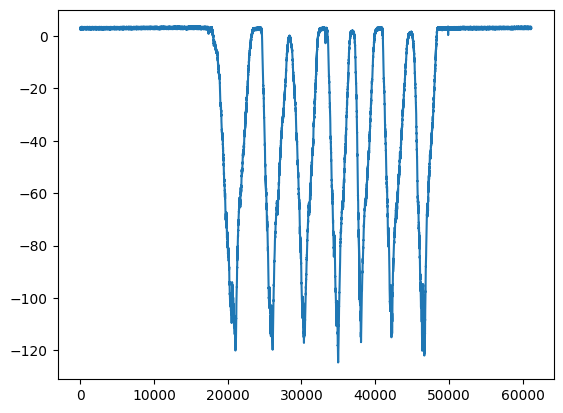

In [75]:
plt.plot(data_force)

Text(0.5, 0, 'Error(meters)')

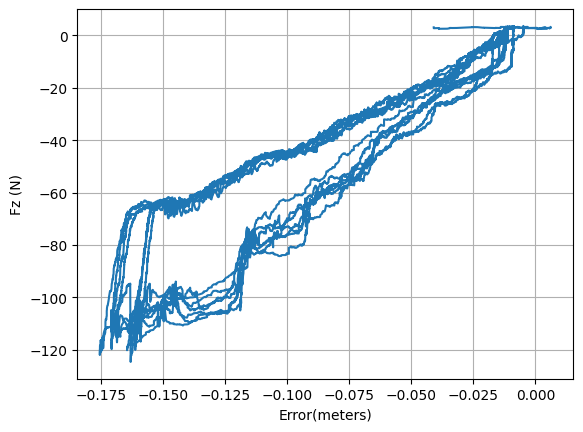

In [77]:
start = 0
end = -1
plt.plot(data_error[start:end], data_force[start:end])
plt.grid(True)
plt.ylabel('Fz (N)')
plt.xlabel('Error(meters)')